In [77]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math
np.random.seed(32)


#def __init__(self):
epsilon = 0.152*0.043  # kcal/mol to ev/atom *Å/(e^2)
sigma = 3.1507  # Units are Ångströms
charge_O = -0.834  # Units are elementary charges (e)
charge_H = 0.417  # Units are elementary charges (e)
k = 450*0.043 # Convert kcal/mol *Å/(e^2) to ev/atom *Å/(e^2)

@cuda.jit(device=True)
def LJ(r):
    return 4*epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

@cuda.jit(device=True)
def coulomb_interactions(r):
    result = 0.0
    for i in range(r.shape[0]):  # Loop through each element if `r` is indeed an array
        result += k* charge_H * charge_O / r[i]
    return result
    
@cuda.jit
def calculate_TIP3P_potential(rO_O, r, energy):
    idx = cuda.grid(1)
    if idx < r.size:
        # here r is a numpy array contains OH OO and HH interactions
        energy[idx] = LJ(rO_O[idx]) + coulomb_interactions(r[idx])

@cuda.jit
def calculate_Coulomb_potential(r, energy):
    idx = cuda.grid(1)
    if idx < r.size:
        # here r is a numpy array contains OH OO and HH interactions
        energy[idx] = coulomb_interactions(r[idx])

@cuda.jit
def calculate_LJ_potential(rO_O, energy):
    idx = cuda.grid(1)
    if idx < rO_O.size:
        # here r is a numpy array contains OH OO and HH interactions
        energy[idx] = LJ(rO_O[idx])

@cuda.jit(device=True)
def calculate_molecule_positions(oxygen_positions, hydrogen_positions, idx, bond_length, sin_angle, cos_angle):
    """
    Calculate hydrogen positions for a given oxygen position in a water molecule.
    
    Parameters:
    - oxygen_position: np.array, coordinates of the oxygen atom.
    - bond_length: float, O-H bond length in angstroms.
    - angle_deg: float, angle between O-H bonds in degrees.
    
    Returns:
    - np.array containing positions for both hydrogen atoms.
    """

    # Position calculations using polar coordinates conversion to Cartesian coordinates
    hydrogen_positions[idx, 0, 0] = oxygen_positions[idx, 0] + bond_length * sin_angle
    hydrogen_positions[idx, 0, 1] = oxygen_positions[idx, 1] + bond_length * cos_angle
    hydrogen_positions[idx, 0, 2] = oxygen_positions[idx, 2]

    hydrogen_positions[idx, 1, 0] = oxygen_positions[idx, 0] - bond_length * sin_angle
    hydrogen_positions[idx, 1, 1] = oxygen_positions[idx, 1] + bond_length * cos_angle
    hydrogen_positions[idx, 1, 2] = oxygen_positions[idx, 2]
        
@cuda.jit
def setup_molecule_positions(oxygen_positions, hydrogen_positions):
    angle_deg=52.26
    bond_length=0.9572
    idx = cuda.grid(1)
    if idx < oxygen_positions.shape[0]:
        angle_rad = math.radians(angle_deg)
        sin_angle = math.sin(angle_rad)
        cos_angle = math.cos(angle_rad)
        calculate_molecule_positions(oxygen_positions, hydrogen_positions, idx, bond_length, sin_angle, cos_angle)

In [78]:
epsilon_surface = 100 * 0.043
sigma = 2  # Units are Ångströms
@cuda.jit(device=True)
def surface_interaction_potential(r):
    return 4*epsilon_surface * ((sigma / r) ** 12 - (sigma / r) ** 6)

@cuda.jit
def calculate_surface_potential(r, energy):
    idx = cuda.grid(1)
    if idx < r.size:
        energy[idx] = surface_interaction_potential(r[idx])

def calculate_surface_potential_cpu(r):
    return 4*epsilon_surface * ((sigma / r) ** 12 - (sigma / r) ** 6)

In [79]:
class NVT_ensemble:
    def __init__(self, box_size):
        self.number_density = 997e3/18.015*6.02214e23 #particles/M^3
        self.box_size = box_size #unit in M
        self.particle_number = int(box_size**3*self.number_density)
        self.effective_diameter = 2.5 #unit in Angstrong
        self.positions_all = None
        self.particle_types = None

    def MIC_conversion(self, vector, box_length):
        return vector - np.round(vector / box_length) * box_length
        
    def initialize_particle_in_box(self):
        positions_o = np.zeros((self.particle_number, 3))
        positions_h = np.zeros((self.particle_number, 2, 3))
        
        N = self.particle_number
        threads_per_block = 256
        blocks_per_grid = (N + threads_per_block - 1) // threads_per_block
        for i in range(self.particle_number):
            while True:
                new_pos = np.random.rand(3) * self.box_size *1e10
                distances = np.linalg.norm(self.MIC_conversion(new_pos - positions_o[:i], self.box_size*1e10), axis=1)
                if not any(distances < self.effective_diameter) and new_pos[2]>2:
                    positions_o[i] = new_pos
                    break
        setup_molecule_positions[blocks_per_grid, threads_per_block](positions_o, positions_h)
        self.positions_all = np.concatenate((positions_o[:, np.newaxis, :], positions_h), axis=1)
        self.particle_types = np.repeat([[0, 1, 1]], N, axis=0)
        
    def get_positions(self):
        return self.positions_all
    
    def get_particle_types(self):
        return self.particle_types
    
ensemble = NVT_ensemble(3e-9)
ensemble.initialize_particle_in_box()
positions = ensemble.get_positions()
print(positions.shape)
particle_types = ensemble.get_particle_types().flatten()
ensemble.particle_number

(899, 3, 3)


c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


899

In [80]:
import time
from copy import deepcopy
class Monte_Carlo:
    def __init__(self, positions, steps, box_size, beta, r_cutoff):
        self.positions = positions #(N, 3, 3)
        self.molecule_number = len(positions)
        self.steps = steps
        self.box_size = box_size
        self.beta = beta
        self.cut_off = r_cutoff
        #self.particle_types = particle_types #(N,3)
        self.energy = self.total_energy_calc(self.positions, self.cut_off, self.box_size)
        self.energy_history = []
        self.acc_ratio_history = []

    def MIC_conversion(self, vector, box_length):
        vector[:, :2] -= np.round(vector[:, :2] / box_length) * box_length
        return vector

    def total_energy_calc(self, positions, r_cutoff, box_length):
        #positions = positions.reshape(-1, positions.shape[2])
        real_space_potential = 0.0
        N = len(positions)

        for i in range(N-1):
            oxygen_positions = positions[i+1:, 0]
            hydrogen_positions = positions[i+1:, 1:]
            rO_O = np.linalg.norm(self.MIC_conversion(positions[i, 0] - oxygen_positions, box_length))
            rO_O = rO_O[rO_O<r_cutoff]

            r = self.MIC_conversion(positions[i, 0] - hydrogen_positions, box_length)
            r = np.concatenate((r, self.MIC_conversion(oxygen_positions - positions[i, 1], box_length)[:, np.newaxis, :]), axis=1)
            r = np.concatenate((r, self.MIC_conversion(oxygen_positions - positions[i, 2], box_length)[:, np.newaxis, :]), axis=1)
            r = np.linalg.norm(r, axis=2)
            r = (r[r<r_cutoff])[:, np.newaxis]

            d_r = cuda.to_device(r)
            d_rO_O = cuda.to_device(rO_O)
            
            d_energy_coulomb = cuda.to_device(np.zeros(r.shape[0]))
            d_energy_LJ = cuda.to_device(np.zeros_like(rO_O))

            threads_per_block = 256
            blocks_per_grid = (threads_per_block - 1 + len(r))//threads_per_block

            calculate_Coulomb_potential[blocks_per_grid, threads_per_block](d_r, d_energy_coulomb)

            threads_per_block = 256
            blocks_per_grid = (threads_per_block - 1 + len(r))//threads_per_block
            calculate_LJ_potential[blocks_per_grid, threads_per_block](d_rO_O, d_energy_LJ)
            
            real_space_potential += np.sum(d_energy_LJ.copy_to_host()) + np.sum(d_energy_coulomb.copy_to_host())
        
        threads_per_block = 256
        blocks_per_grid = (threads_per_block - 1 + len(r))//threads_per_block
        z_positions = positions[:, 0, 2]
        z_positions = np.ascontiguousarray(z_positions)
        d_zpositions = cuda.to_device(z_positions)
        d_energy = cuda.to_device(np.zeros_like(z_positions))
        calculate_surface_potential[blocks_per_grid, threads_per_block](d_zpositions, d_energy)
        real_space_potential += np.sum(d_energy.copy_to_host())
        return real_space_potential
    
    def energy_update(self, old_position, particle_index):
        new_position = self.positions[particle_index]
        indexes = np.arange(self.molecule_number)
        other_molecule_pos = self.positions[indexes != particle_index]
        threads_per_block = 128
        blocks_per_grid = (threads_per_block - 1 + self.molecule_number - 1)//threads_per_block
        pairs = np.array([old_position[0]-other_molecule_pos[:, 0], 
                            old_position[0]-other_molecule_pos[:, 1],
                            old_position[0]-other_molecule_pos[:, 2],
                            old_position[1]-other_molecule_pos[:, 0],
                            old_position[2]-other_molecule_pos[:, 0]])
        pairs = pairs.swapaxes(0, 1)
        distances = np.linalg.norm(self.MIC_conversion(pairs, self.box_size), axis=2)
        d_distances = cuda.to_device(distances)
        d_old_energy = cuda.to_device(np.zeros(distances.shape[0]))
        calculate_TIP3P_potential[blocks_per_grid, threads_per_block](d_distances[:, 0], d_distances[:, 1:], d_old_energy)
        pairs = np.array([new_position[0]-other_molecule_pos[:, 0], 
                            new_position[0]-other_molecule_pos[:, 1],
                            new_position[0]-other_molecule_pos[:, 2],
                            new_position[1]-other_molecule_pos[:, 0],
                            new_position[2]-other_molecule_pos[:, 0]])
        pairs = pairs.swapaxes(0, 1)
        distances = np.linalg.norm(self.MIC_conversion(pairs, self.box_size), axis=2)
        d_distances = cuda.to_device(distances)
        d_new_energy = cuda.to_device(np.zeros(distances.shape[0]))
        calculate_TIP3P_potential[blocks_per_grid, threads_per_block](d_distances[:, 0], d_distances[:, 1:], d_new_energy)
        
        z_energy_diff = calculate_surface_potential_cpu(new_position[0, 2]) - calculate_surface_potential_cpu(old_position[0, 2])
        return np.sum(d_new_energy.copy_to_host())-np.sum(d_old_energy.copy_to_host()) + z_energy_diff

    def metropolis_step(self, positions, box_size, beta):
        """Perform one Metropolis Monte Carlo step."""
        N = len(positions)
        i = np.random.randint(N)  # Randomly select a particle
        old_position = deepcopy(positions[i])

        # Propose a move
        displacement = 0.5*np.random.randn(3)  # Small random displacement
        positions[i] += displacement

        # Apply periodic boundary conditions
        positions[i] %= box_size

        delta_energy = self.energy_update(old_position, i)

        if delta_energy > 0 and np.random.rand() >= np.exp(-beta * delta_energy):
            positions[i] = old_position  # Reject move
            self.positions = positions
            return 0
        
        self.positions = positions
        self.energy += delta_energy
        return 1

    def simulate(self):
    # Run the simulation
        for step in range(self.steps):
            count = 0
            for _ in range(self.molecule_number):
                acc = self.metropolis_step(self.positions, self.box_size, self.beta)
                count += acc
                self.energy_history.append(self.energy)
            self.acc_ratio_history.append(count/self.molecule_number)


simuation = Monte_Carlo(positions, 2000, 30, 1/(8.617e-5*300), 40)
print(simuation.energy)

c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 15 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 15 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 14 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarnin

-823954.502844693


c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [81]:
start_time = time.time()
simuation.simulate()
end_time = time.time()
print(end_time-start_time)

c:\Users\xianyang chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2043.9797430038452


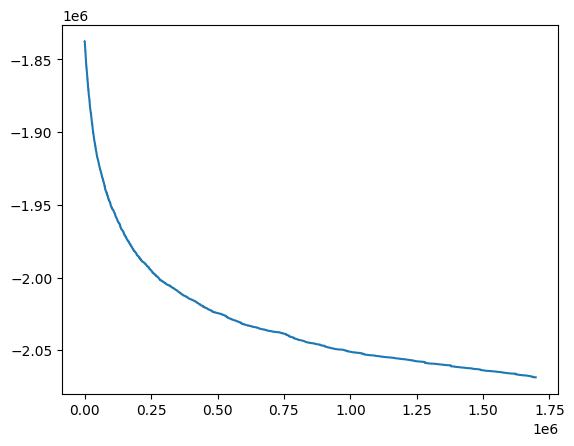

In [82]:
plt.plot(simuation.energy_history[100000:])

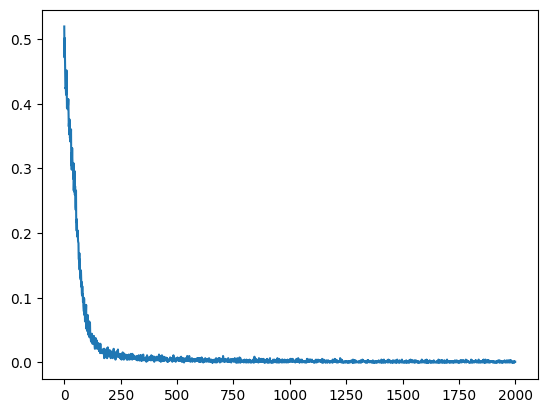

In [83]:
plt.plot(simuation.acc_ratio_history)

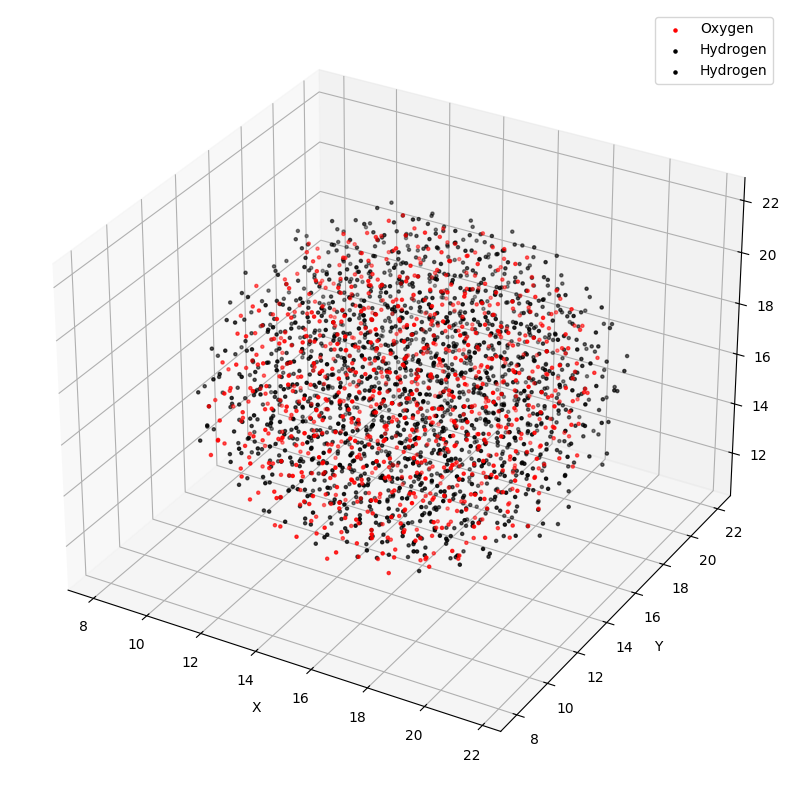

In [84]:
from mpl_toolkits.mplot3d import Axes3D

positions = simuation.positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
marker_size = 5

ax.scatter(positions[:, 0, 0], positions[:, 0, 1], positions[:, 0, 2], color='red', label="Oxygen", s=marker_size)
ax.scatter(positions[:, 1, 0], positions[:, 1, 1], positions[:, 1, 2], color='black', label="Hydrogen", s=marker_size)
ax.scatter(positions[:, 2, 0], positions[:, 2, 1], positions[:, 2, 2], color='black', label="Hydrogen", s=marker_size)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

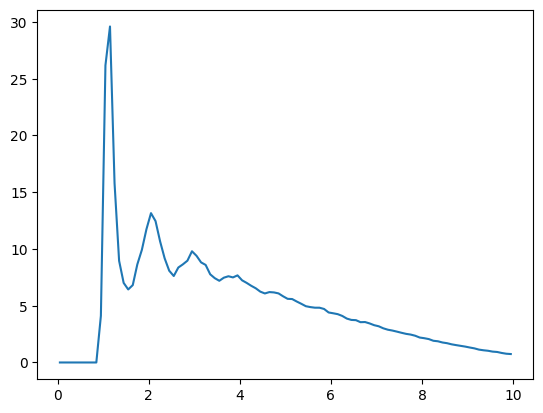

In [85]:
def compute_rdf(positions, rlo, gcut, L, num_bins=100):
    nax = np.newaxis
    positions = positions
    num_particles = len(positions)
    density = num_particles / np.prod(L)
    # Compute distances between particles
    dist_matrix = np.linalg.norm(positions[nax, :, :] - positions[:, nax, :], axis=-1)
    indicies = np.triu_indices_from(dist_matrix, k=1)
    all_distances = dist_matrix[indicies]
    # Compute histogram of distances
    rhos, bin_edges = np.histogram(a=all_distances, bins=num_bins, range=(rlo, gcut), density=False)
    # Normalize RDF
    shell_volumes = 4/3*np.pi*(bin_edges[1:]**3-bin_edges[:-1]**3)
    rdf = (rhos / shell_volumes*density)/num_particles
    bin_centers = bin_edges[:-1] + (bin_edges[1:]-bin_edges[:-1])/2
    return bin_centers, rdf

radius_array, rdf_array = compute_rdf(positions[:,0], 0, 10, 30)

plt.plot(radius_array, rdf_array)

Text(0, 0.5, 'prob of particle distribution')

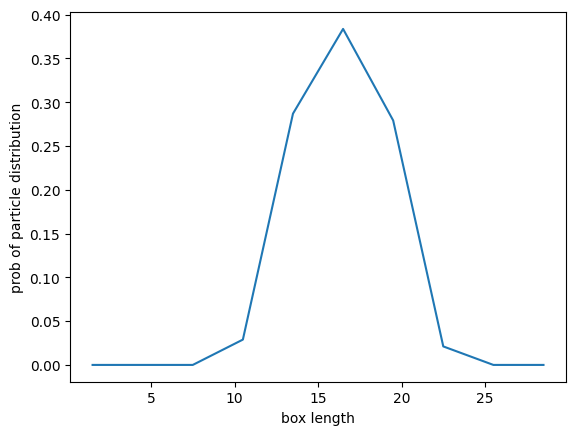

In [89]:
def get_z_positions_distribution(z_positions, number_bins, rlo, gcut):
    rhos, bin_edges = np.histogram(a=z_positions, bins=number_bins, range=(rlo, gcut), density=False)
    bin_centers = bin_edges[:-1] + (bin_edges[1:]-bin_edges[:-1])/2
    return rhos, bin_centers

z_values, z_pos_array = get_z_positions_distribution(positions[:, 0, 2], 10, 0, 30)
plt.plot(z_pos_array, z_values/len(positions))
plt.xlabel("box length")
plt.ylabel("prob of particle distribution")